In [1]:
import scrap_lyrics

import requests
import re
from bs4 import BeautifulSoup as bs# import beautiful soup = bs
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import wordcloud

## Get lyrics of two artists


### Construct complete URL and create list of URL's and titles

In [2]:
result_amy, titles_amy= scrap_lyrics.get_artists_link('https://www.lyrics.com/artist/Amy+Winehouse/612371', 'Amy+Winehouse')
result_adele, titles_adele= scrap_lyrics.get_artists_link('https://www.lyrics.com/artist/Adele/861756', 'Adele')
result_cardi, titles_cardi= scrap_lyrics.get_artists_link('https://www.lyrics.com/artist/Cardi+B/3195462', 'Cardi+B')

### Download and spacify lyrics and zip to titles

In [3]:
customize_stop_words = ['don', 've', 'll', 'ain', 't', 's', 'm', 'd', 're']

In [4]:
adele_df, adele_list, adele_spacy= scrap_lyrics.get_lyrics(result_adele, titles_adele, 'Adele', customize_stop_words, totext= True)
amy_df, amy_list, amy_spacy= scrap_lyrics.get_lyrics(result_amy, titles_amy, 'AmyD', customize_stop_words)
cardi_df, cardi_list, cardi_spacy= scrap_lyrics.get_lyrics(result_cardi, titles_cardi, 'CardiB', customize_stop_words)


In [16]:
cardi_df.head()

,title,lyrics,artist,spacified_lyric,sentiment_comp
0,Press,Monsta s gon tear it up Bardi Woo yeah B...,CardiB,monsta gon tear bardi woo yeah bitch...,Negative
1,Bartier Cardi,Bardi in a Rari diamonds all over my body S...,CardiB,bardi rari diamond body shinin body ...,Negative
2,Bodak Yellow,Said little bitch you can t fuck with me If ...,CardiB,say little bitch fuck want expensive r...,Negative
3,Back It Up,Yeah Cardi B Hoodcelebrityy Hey gal beg ...,CardiB,yeah cardi b hoodcelebrityy hey gal ...,Positive
4,Bronx Season,Oh how you doin I m alright Man turn this...,CardiB,oh do alright man turn shit man ...,Negative


In [14]:
amy_df.head()

,title,lyrics,artist,spacified_lyric,sentiment_comp
0,Amy Amy Amy,Attracts me till it hurts to concentrate Di...,AmyD,attract till hurt concentrate distract ...,Negative
1,Cherry,Her name is Cherry we ve just met But alread...,AmyD,cherry meet know better understand eight...,Positive
2,Teo Licks,There I go there I go there I go there I go...,AmyD,pretty baby soul snap control funny thing ...,Positive
3,Fuck Me Pumps,When you walk in the bar And you dressed like ...,AmyD,walk bar dress like star rockin f pump man n...,Positive
4,Help Yourself,When I walk in your shoes I understand a man ...,AmyD,walk shoe understand man confuse care fe...,Positive


### Generate Wordcloud


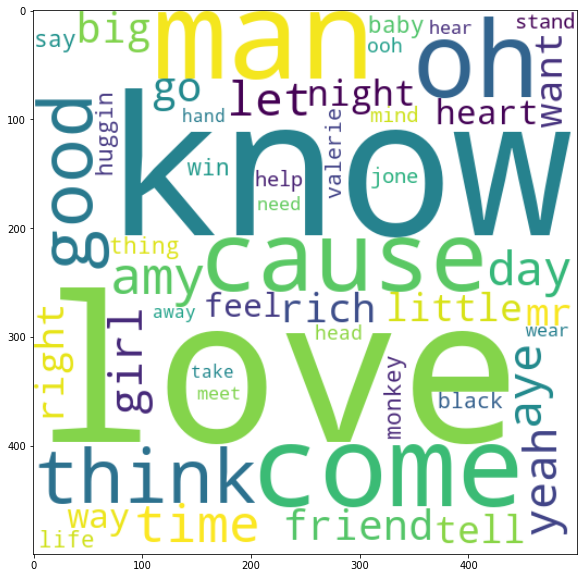

In [7]:
amy_songs= ' '.join(amy_spacy)
adele_songs= ' '.join(adele_spacy)
cardi_songs= ' '.join(cardi_spacy)

mask = np.zeros((500, 500, 3), np.uint8)
mask[50:70, 50:70,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                mask=mask,
                collocations= False,  # calculates frequencies
                contour_color='steelblue').generate(amy_songs)
                # stop words are removed!

plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.savefig('cloud.png')
plt.show()

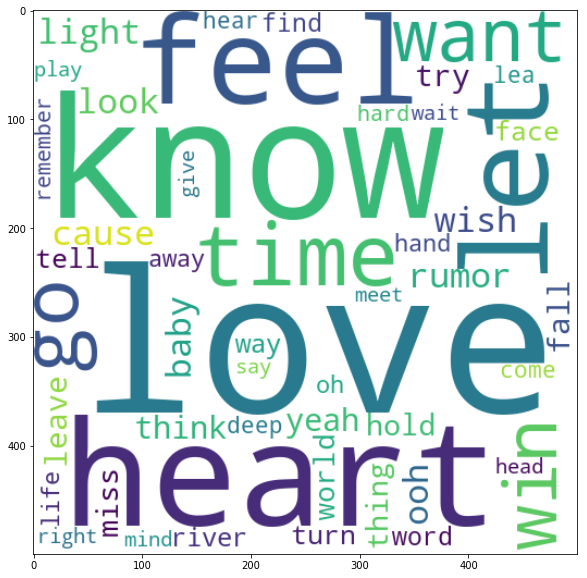

In [8]:
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                mask=mask,
                collocations= False,  # calculates frequencies
                contour_color='steelblue').generate(adele_songs)
                # stop words are removed!

plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.savefig('cloud.png')
plt.show()

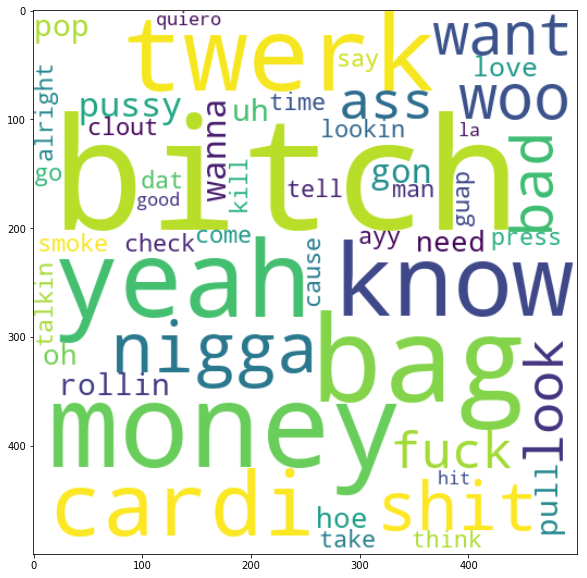

In [9]:
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                mask=mask,
                collocations= False,  # calculates frequencies
                contour_color='steelblue').generate(cardi_songs)
                # stop words are removed!

plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.savefig('cloud.png')
plt.show()

### Drop duplicate songs and concat df's


In [10]:
amy_df.drop(amy_df.index[[5, 21, 25, 37, 19]], inplace= True)
master= pd.concat([amy_df, adele_df], ignore_index= True)

### Train-test-split

In [17]:
X= master['spacified_lyric']
y= master['artist']

Xtrain, Xtest, ytrain, ytest= train_test_split(X,y,random_state=42)

### Vectorize the text corpus and apply a TF-IDF transformation to Xtrain and Xtest

In [26]:
cv = CountVectorizer(min_df= 5)
Xtrain_cv= cv.fit_transform(Xtrain)
tf= TfidfTransformer()
Xtrain_tf= tf.fit_transform(Xtrain_cv)

In [27]:
Xtest_cv= cv.transform(Xtest)
Xtest_tf= tf.transform(Xtest_cv)

### Import the Multinomial Naive Bayes model from sklearn and fit it on our transformed vector (X) and our artist labels (y)

In [38]:
m = MultinomialNB(alpha= 2.0)
m.fit(Xtrain_tf, ytrain)
ypred= m.predict(Xtest_tf) #predictions
proba= m.predict_proba(Xtest_tf) #probabilities

### Which words in the data were the most important?

In [39]:
prob_log = m.feature_log_prob_
diff = prob_log[0] - prob_log[1] 

sns.set(font_scale=1.5)
%matplotlib inline
imp= pd.DataFrame(data=diff, index=sorted(cv.vocabulary_.keys())).sort_values(by=0)
imp.iloc[np.r_[0:5, -5:0]]

,0
man,-1.057188
come,-0.692492
bed,-0.472840
bout,-0.427936
get,-0.417411
word,0.460622
give,0.496989
heart,0.505646
feel,0.508792
wish,0.529837


### Create prediction df

In [40]:
compare= pd.DataFrame(zip(list(ytest), list(Xtest), list(proba[:,0]), list(proba[:,1])), index= list(ypred), columns= ['actual_artist', 'lyrics', 'proba_adele', 'proba_amy'])

In [31]:
compare

,actual_artist,lyrics,proba_adele,proba_amy
AmyD,AmyD,meet downstairs bar hear roll sleeve skull s...,0.455473,0.544527
AmyD,AmyD,attract till hurt concentrate distract ...,0.460085,0.539915
AmyD,AmyD,man fight unholy war straight shake st...,0.418523,0.581477
Adele,AmyD,leave time regret keep lip wet old safe be...,0.700051,0.299949
AmyD,AmyD,time friend safe evening cause dri...,0.458799,0.541201
Adele,AmyD,cupid draw bow let arrow flow straight...,0.526016,0.473984
Adele,AmyD,strong seven year longer know suppose man ...,0.558262,0.441738
Adele,Adele,want single piece want heaven ocean treat ...,0.517615,0.482385
Adele,AmyD,walk shoe understand man confuse care fe...,0.525168,0.474832
Adele,AmyD,tonight completely soul sweetly tonight ...,0.613086,0.386914


In [41]:
m.score(Xtest_tf, list(ytest))

0.65

In [42]:
m.score(Xtrain_tf, list(ytrain))

0.9152542372881356